In [1]:
import cv2

In [2]:
# ==============================
# FEATURE EXTRACTION EXPERIMENT
# ==============================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# 1. DEFINE DATA VARIATIONS
# ---------------------------

# Resize to 224x224 for ResNet
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

normalize = transforms.Normalize((0.5,), (0.5,))

normalized_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

# Dataset dictionary
transform_variations = {
    "Base": base_transform,
    "Normalized": normalized_transform,
    "Normalized + Augment": augment_transform,
    "Normalized + Augment + Regularize": augment_transform  # regularization in model, not transform
}

# ---------------------------
# 2. TRAINING & EVALUATION LOOP
# ---------------------------

def train_feature_extraction(model, train_loader, val_loader, epochs=3, lr=1e-3, regularize=False):
    # Freeze all layers except final classifier
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=lr, weight_decay=1e-4 if regularize else 0.0)

    train_losses, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        val_acc,_,_ = evaluate(model, val_loader)
        train_losses.append(avg_loss)
        val_accs.append(val_acc)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return train_losses, val_accs


def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    acc = 100 * correct / total
    return acc, np.array(all_preds), np.array(all_labels)



In [3]:
# ---------------------------
# 3. GRAD-CAM IMPLEMENTATION
# ---------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach().clone()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach().clone()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_image, target_class=None):
        self.model.zero_grad()
        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        loss = output[0, target_class]
        loss.backward()

        if self.gradients is None:
            raise RuntimeError("Gradients were not captured. Check target_layer or hooks.")

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1).squeeze()
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        cam = cam.cpu().numpy()
        return cam, target_class


In [4]:
def gradcam_evaluate(model, data):
    model.eval()
    data = data.to(device)
    data.requires_grad_()  # ✅ needed for Grad-CAM
    target_layer = model.layer4[-1]  # example for ResNet
    grad_cam = GradCAM(model, target_layer)
    cam, cls = grad_cam.generate(data)
    return cam, cls

In [17]:
def plot_training_progress(history_dict):
    """
    history_dict = {
        "Baseline": {"train_acc": [...], "val_acc": [...]},
        "Normalized": {"train_acc": [...], "val_acc": [...]},
        "Augment + Normalize": {...},
        ...
    }
    """
    plt.figure(figsize=(8,6))
    for name, history in history_dict.items():
        plt.plot(history["val_acc"], label=f"{name} (Val)")
        plt.plot(history["train_acc"], '--', alpha=0.5, label=f"{name} (Train)")
    
    plt.title("Training Progress Across Model Variations")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

In [ ]:
# ---------------------------
# 4. RUN EXPERIMENTS
# ---------------------------
history = {"train_acc": [], "val_acc": []}
results = []
for variation_name, transform in transform_variations.items():
    print(f"\n🔹 Running {variation_name} dataset")

    dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    # Load model
    model = models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Sequential(
        nn.Dropout(0.5 if "Regularize" in variation_name else 0.0),
        nn.Linear(model.fc.in_features, 10)
    )
    model = model.to(device)

    # Train & Evaluate
    train_feature_extraction(model, train_loader, val_loader, epochs=3, regularize="Regularize" in variation_name)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    test_acc, preds, labels = evaluate(model, test_loader)
    print(f"✅ {variation_name} Test Accuracy: {test_acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {variation_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    results.append({"Variation": variation_name, "Accuracy": test_acc})

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
    # Flatten the axes array to easily iterate through the 12 spots
    axes_flat = axes.flatten()

    # --- 2. Loop for the 10 Plots ---
    for i in range(10):
        # Get the specific Axes object for the current plot (i-th subplot)
        ax = axes_flat[i]

        # --- Your original code to generate data ---
        idx = np.where(np.array(test_dataset.targets) == i)[0][0]
        img, _ = test_dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)
        input_tensor.requires_grad_()
        cam, cls = grad_cam.generate(input_tensor)
        
        # Ensure cam_resized has the same width/height as the image data
        # Note: img.shape[1] is height, img.shape[2] is width for C x H x W tensor
        cam_resized = cv2.resize(cam, (img.shape[2], img.shape[1])) 
        # ---------------------------------------------

        # --- 3. Plot on the Current Axis (ax) ---
        # Use ax.imshow() and ax.set_title() instead of plt.imshow() and plt.title()
        ax.imshow(img.squeeze().cpu().numpy(), cmap="gray") # Added .cpu().numpy() to handle PyTorch tensor
        ax.imshow(cam_resized, cmap="jet", alpha=0.5)
        ax.set_title(f"Label {i}, Predicted {cls}")
        ax.axis("off") # Turn off the axis ticks/labels for this specific subplot

    # --- 4. Clean up the unused subplots (Indices 10 and 11) ---
    # Since we only have 10 plots but a 12-spot grid, hide the last 2 subplots
    # for j in range(10, 12):
    #     fig.delaxes(axes_flat[j])

    # --- 5. Display the entire figure ONCE ---
    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()

    # # Grad-CAM Visualization
    # # 🧠 Step 1: Get one image and move to device
    # sample_img, _ = test_dataset[0]
    # input_tensor = sample_img.unsqueeze(0).to(device)

    # # 🧠 Step 2: Ensure the tensor requires gradient for Grad-CAM
    # input_tensor.requires_grad_()   # <-- IMPORTANT

    # # 🧠 Step 3: Define target layer (example for ResNet)
    # # You can also pick other layers like model.layer3[-1].conv2 for deeper maps
    # target_layer = model.layer4[-1].conv2

    # # 🧠 Step 4: Initialize GradCAM
    # grad_cam = GradCAM(model, target_layer)

    # # 🧠 Step 5: Generate the CAM
    # cam, cls = grad_cam.generate(input_tensor)

    # # 🧠 Step 6: Convert image and resize CAM for overlay
    # img_np = sample_img.squeeze().cpu().numpy()
    # cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))

    # # 🧠 Step 7: Visualize the result
    # plt.figure(figsize=(5, 5))
    # plt.imshow(img_np, cmap="gray")
    # plt.imshow(cam_resized, cmap="jet", alpha=0.5)
    # plt.title(f"Grad-CAM - {variation_name} (Predicted Class: {cls})")
    # plt.axis("off")
    # plt.show()



🔹 Running Base dataset


/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

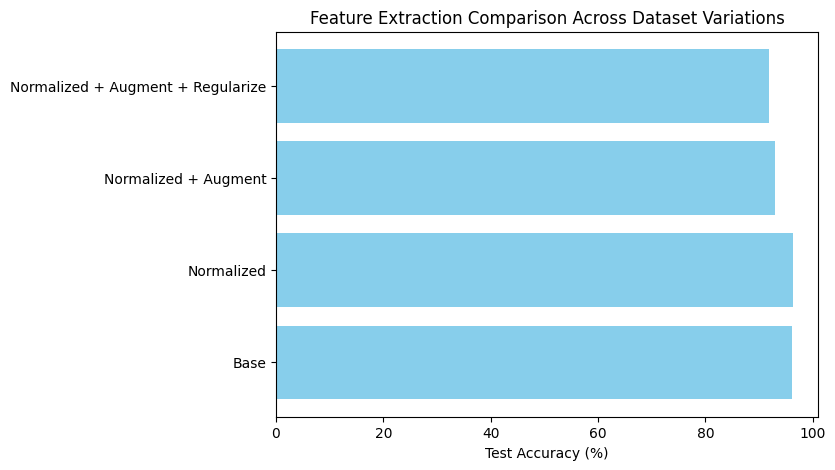

In [6]:
# ---------------------------
# 5. COMPARISON BAR CHART
# ---------------------------

plt.figure(figsize=(7,5))
names = [r["Variation"] for r in results]
values = [r["Accuracy"] for r in results]
plt.barh(names, values, color='skyblue')
plt.xlabel("Test Accuracy (%)")
plt.title("Feature Extraction Comparison Across Dataset Variations")
plt.show()

/tmp/ipykernel_2365/3411168493.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]


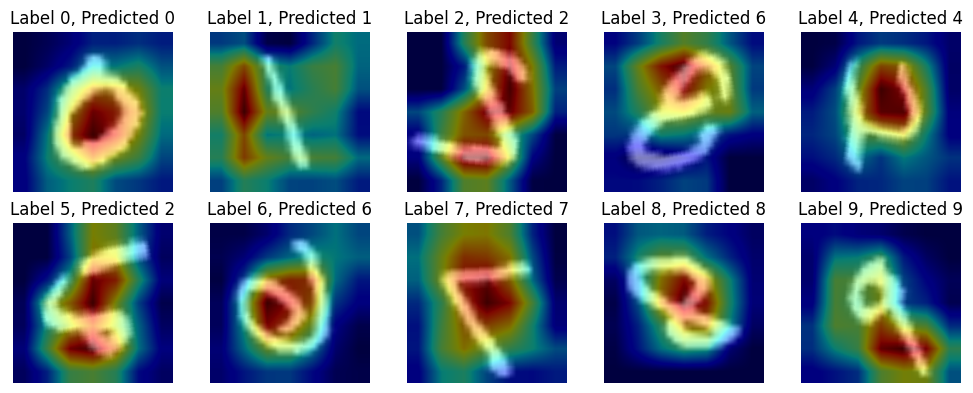

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
# Flatten the axes array to easily iterate through the 12 spots
axes_flat = axes.flatten()

# --- 2. Loop for the 10 Plots ---
for i in range(10):
    # Get the specific Axes object for the current plot (i-th subplot)
    ax = axes_flat[i]

    # --- Your original code to generate data ---
    idx = np.where(np.array(test_dataset.targets) == i)[0][0]
    img, _ = test_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad_()
    cam, cls = grad_cam.generate(input_tensor)
    
    # Ensure cam_resized has the same width/height as the image data
    # Note: img.shape[1] is height, img.shape[2] is width for C x H x W tensor
    cam_resized = cv2.resize(cam, (img.shape[2], img.shape[1])) 
    # ---------------------------------------------

    # --- 3. Plot on the Current Axis (ax) ---
    # Use ax.imshow() and ax.set_title() instead of plt.imshow() and plt.title()
    ax.imshow(img.squeeze().cpu().numpy(), cmap="gray") # Added .cpu().numpy() to handle PyTorch tensor
    ax.imshow(cam_resized, cmap="jet", alpha=0.5)
    ax.set_title(f"Label {i}, Predicted {cls}")
    ax.axis("off") # Turn off the axis ticks/labels for this specific subplot

# --- 4. Clean up the unused subplots (Indices 10 and 11) ---
# Since we only have 10 plots but a 12-spot grid, hide the last 2 subplots
# for j in range(10, 12):
#     fig.delaxes(axes_flat[j])

# --- 5. Display the entire figure ONCE ---
plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()